# Checkpoint 3: Variational Autoencoder & Generative and adversarial models
---
*Responsible:* Guillermo Hamity (<ghamity@ed.ac.uk>)


Quickdraw was an interesting dataset but requires quite a lot of CPU to get decent results. We discussed a relatively good solution to the problem in the Lecture, but it is quite CPU intensive.

In order to make life a little easier in terms of training time, in this checkpoint exercise we will work with the MNIST dataset of hand-written digits. This time, though, we won't be classifying existing images, we will be generating new ones with generative models. 

- Exersice 1 and 2 we will build and use a Variational Autoencoder
- Exersice 3 we will use a Generative Adeverserial Network


These exercises build quite heavily on the ones in CP2. The network structure that worked on quickdraw should translate pretty well to MNIST, and hopefully perform better. You may be able to reuse some of your work, or you can look at my proposed solutions from last time for inspiration.


### Notes on assessment
* Try and calculate the answers to the exercises provided. If you are unable to complete the question, describe which approach you _would_ have taken to solve the problem
* Code must be understandable and reproducible. Before grading the notebook kernel **may** be restarted and re-run, so make sure that your code can run from start to finish without any (unintentional) errors
* If you are unsure on how to proceed please **ask one of the TAs** during the workshop
- Notebooks should be submitted by **10am on Friday 29 November 2020** 
- This CP exercise sheet is divided into **3 sections** giving a maximum of **10 marks** in total:

| <p align='left'> Title                        | <p align='left'> Exercise nos. | <p align='center'> Number of marks |
| ------------------------------------------------------ | --------------------- | ------------------ |
| <p align='left'> 1. Build VAE                          | <p align='left'> 1–3  | <p align='left'> 4 |
| <p align='left'> 2. Compile and train a VAE            | <p align='left'> 4–6  | <p align='left'> 4 | 
| <p align='left'> 3. Generative adversarial network     | <p align='left'> 7–9  | <p align='left'> 2 |
| <p align='left'> **Total**                             |                       | <p align='left'> **10** |

## Preamble
---

In [1]:
# Standard import(s)
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

C:\ProgramData\Anaconda3\envs\daml\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\ProgramData\Anaconda3\envs\daml\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\ProgramData\Anaconda3\envs\daml\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\ProgramData\Anaconda3\envs\daml\lib\site-packages\tensorflow\python\frame

In [2]:
# Keras import(s)
from tensorflow.python.keras.utils.vis_utils import plot_model
from tensorflow.python.keras.models import Model, Sequential
from tensorflow.python.keras.layers import Input, Dense, Dropout, Flatten, Reshape, Conv2D, Conv2DTranspose, Concatenate, Lambda,BatchNormalization, UpSampling2D,MaxPooling2D
from tensorflow.python.keras import backend as K
from tensorflow.python.keras.losses import binary_crossentropy
from tensorflow.python.keras.layers.advanced_activations import LeakyReLU
from tensorflow.python.keras.backend import set_image_data_format
from tensorflow.keras.optimizers import Adam
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()
set_image_data_format('channels_last')  # Images are formatted as (N, N, 1), with colour-channels last



## Data preprocessing
---

First, we'll load in the MNIST dataset from TensorFlow, which has already been split into training and testing parts for us.

In [3]:
# Load in MNIST dataset 
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()

# Get numbers
nb_train   = X_train.shape[0]
nb_test    = X_test .shape[0]
nb_classes = y_train.max() + 1
print(f"Number of training examples: {nb_train}")
print(f"Number of testing  examples: {nb_test}")
print(f"Number of target classes:    {nb_classes}")

# Reshape inputs to (N,N,1), i.e. have one colour dimension
X_train = X_train[..., np.newaxis]
X_test  = X_test [..., np.newaxis]

# Standardise inputs
print("Max. input before scaling: {}".format(X_train.max()))
X_train = X_train / 255.
X_test  = X_test  / 255.

# Get image shape
shape = X_train.shape[1:]
print(f"Image shape:  {shape}")

# Shuffle (dataset is pre-shuffled, but still)
ix_train = np.random.permutation(nb_train)
ix_test  = np.random.permutation(nb_test)

X_train = X_train[ix_train]
y_train = y_train[ix_train]

X_test  = X_test [ix_test]
y_test  = y_test [ix_test]


Number of training examples: 60000
Number of testing  examples: 10000
Number of target classes:    10
Max. input before scaling: 255
Image shape:  (28, 28, 1)


The image below shows labels and images associated to them. They are in our standard (28,28,1) image format, as we had in quickdraw.

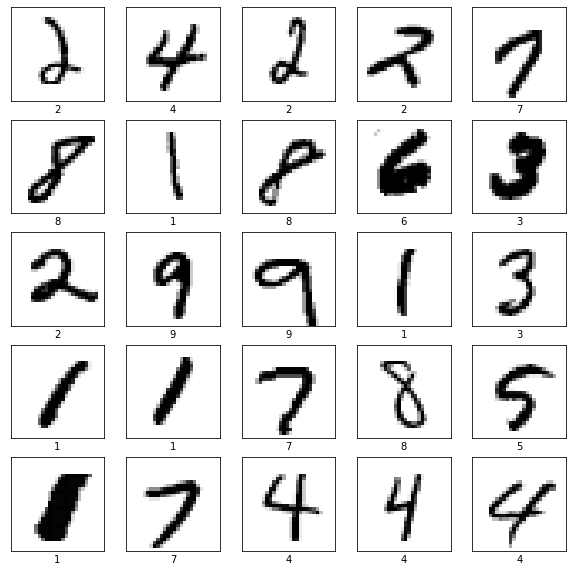

label marks [2 4 2 2 7 8 1 8 6 3 2 9 9 1 3 1 1 7 8 5 1 7 4 4 4]


In [4]:
nb_show = 25
plt.figure(figsize=(10,10))
for i in range(nb_show):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_train[i], cmap=plt.cm.binary)
    plt.xlabel(y_train[i])
plt.show()
print("label marks",y_train[:nb_show])

## Variational auto-encoder (VAE) utilities
---
Below, I am providing you with some utility methods for training VAEs. This is done to minimsie the overhead in getting you up and running and training cool neural networks.

The first function implements the crucial element for _variational_ auto-encoders: The random sampling in the latent space. The `sampling` function below takes one argument, which is assumed to be a list with two element: the means and the logarithm of the variances, respectively, of the latent probability density function (p.d.f.) for a given image example. The function then samples random numbers, and scales them such that they are effectively drawn from a p.d.f. with means and standard deviations as given by `args`. These sampled coordinates in the latent space are then returned.

In [5]:
def sampling (args):

  # Unpack arguments
  z_mean, z_log_var = args

  # Get shape of random noise to sample
  epsilon = K.random_normal(shape=K.shape(z_mean))

  # Return samples from latent space p.d.f.
  return z_mean + K.exp(0.5 * z_log_var) * epsilon

# Build a VAE (4 marks)

#### 1. Build the encoder of the VAE (1.5 mark)

Build an encoder. We will train for 50 epoches so a relatively fast NN may be desiriable. Here you have some freedom but some example structure is given:
- the input layer has the dimension of the shape
- Flat the input layer (either with or without convolution beforehand)
    - The `1 2 4 8 16` convolution example worked well for me, but is a bit slower.
- add a few hidden Dense layer (with relu activation function) with 256 dimension of hidden nodes
- Add the 2 special layers:
    * `z_mean` contains the means of the latent space p.d.f. for a given image, and
    * `z_log_var` contains the logarithm of the assocated variances. 
- Pass these 2 layers into a layer `z` that just apply the `sampling` method above. Note: the sampling method is used to perform the reparametrization trick. `Lambda` has to be used to ensure the gradients to be computed (see Lecture example) 
- Output the 3 layers (z_mean, z_log_var and z)
- build the encoder model with the `Model` method. 
    - If you used convolution and pooling make sure you complient this with Upsampleling and ConvolutionTranspose. 
    - A good structure here is to invert the stucture of the encoder, e.g. `16 8 4 2 1`.

In [6]:
#This cell constructs the encoder
intermediate_dim =256
latent_dim = 2

inputs = Input(shape=shape) #shape is (28,28,1)
flat = Flatten()(inputs)#Flatten the input without convolution layer as it takes too long otherwise
hidden1 = Dense(256, activation='relu')(flat)
hidden2 = Dense(256, activation='relu')(hidden1) #Two hidden layers with 256 nodes each
z_mean = Dense(latent_dim,name='z_mean')(hidden2) #calculate the mean of value in latent space 
z_log_var = Dense(latent_dim,name='z_log_var')(hidden2) #calculate the variance of value in latent spave
z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var]) #combine them

encoder = Model(inputs=inputs, outputs=(z_mean,z_log_var,z),name='encoder')
encoder.summary()


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
flatten (Flatten)               (None, 784)          0           input_1[0][0]                    
__________________________________________________________________________________________________
dense (Dense)                   (None, 256)          200960      flatten[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 256)          65792       dense[0]

#### 2. Build the decoder of the VAE (1.5 mark)

Build a decoder:
- the input layer has the latent space 2
- Apply 2 hidden Dense layers with dimension 256 (same number as in the encoder) and relu activation function
- Output sigmoid activation function such that it ends up with the same shape as the original image, with pixel intensities in the range $[0, 1]$.
    - use as dimension of this layer `np.prod(shape)`, where shape is the latent space.
- then reshape the output to the original image shape with `Reshape` method. This step is needed to bring back the data from shape (latent_dim, ) into some shape that can be reshaped into the output shape of the last layer of our encoder.
- build the decoder model with the `Model` method

In [7]:
#This cell constructs the decoder
#decoder has a mirror image architecture to the encoder

dec_input = Input(shape=latent_dim) #input has same shape as latent shape
dec_hidden1 = Dense(256, activation='relu')(dec_input) 
dec_hidden2 = Dense(256, activation='relu')(dec_hidden1) #2 hidden layers with 256 nodes 
dec_output = Dense(784,activation='sigmoid')(dec_hidden2) #output layer has 28x28x1 nodes with sigmoid activation.
reshaped = Reshape((28,28,1))(dec_output) #reshape output to original image shape

decoder = Model(inputs=dec_input, outputs=reshaped,name='decoder')
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 2)]               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               768       
_________________________________________________________________
dense_3 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_4 (Dense)              (None, 784)               201488    
_________________________________________________________________
reshape (Reshape)            (None, 28, 28, 1)         0         
Total params: 268,048
Trainable params: 268,048
Non-trainable params: 0
_________________________________________________________________


#### 3. Build the VAE model (1 mark)

Then, we can connect the encoder and the decoder. 
- Build the VAE model using `Model` method using `i` (encoder) and `o` (decoder)
- plot the model with the `plot_model` method

In [8]:
## Chain together to get VAE
i = encoder.inputs
if len(i) == 1:
    i = i[0]
    pass
z = encoder(i)[2]
o = decoder(z)

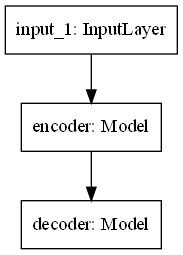

In [9]:
vae = Model(i, o, name='VAE')
plot_model(vae)

# Compile and train the VAE model (3 marks)

The `compile_vae` methods compiles the VAE model passed as the sole argument. The method computes

1. the image reconstruction loss (`reco_loss`), as well as
2. the Kullback-Leibler (KL) loss (`kl_loss`) for the latent space p.d.f.

The first loss measures how well the VAE is doing at reconstructing the input images; the second loss quantifies how continuous the latent representation is. The two losses are then summed (and added as separate metrics for monitoring), and the VAE model is compiled with the Adam optimiser.

In [10]:
def compile_vae (vae):

    # Get the latent p.d.f. mean and log-variance output layers from VAE encoder
    encoder   = vae.get_layer('encoder')
    z_log_var = encoder.get_layer('z_log_var').output
    z_mean    = encoder.get_layer('z_mean').output

    # Define reconstruction loss
    def reco_loss (y_true, y_pred):
        # Use binary cross-entropy loss
        reco_loss_value = binary_crossentropy(y_true, y_pred) # Averages over axis=-1
        reco_loss_value = K.sum(reco_loss_value, axis=(1,2))
        return reco_loss_value

    # Define Kullback-Leibler loss with reference to encoder output layers
    def kl_loss (y_true, y_pred):
        kl_loss_value = 0.5 * (K.square(z_mean) + K.exp(z_log_var) - 1. - z_log_var)
        kl_loss_value = K.sum(kl_loss_value, axis=-1)
        return kl_loss_value

    # Define VAE loss
    def vae_loss (y_true, y_pred):
        return reco_loss(y_true, y_pred) + kl_loss(y_true, y_pred)

    vae.compile(optimizer='adam', loss=vae_loss, metrics=[reco_loss, kl_loss])
    return

#### 4. Construct, compile, and train a VAE using the methods provided above (1 mark)

* Call the model `vae`, and use **2 latent dimensions.**
* Display the model using the `plot_model(vae, show_shapes=True)` method, to validate that it looks as expected.
* Compile the model.
* Train for ca. **50 epochs**, using the testing dataset for validation.
* Plot the all of the loss histories in `vae.history.history`. Use a suitable fraction of training data for validation

In [11]:
# Define parameters
latent_dim =  2
nb_epochs  =  50
batch_size = 128

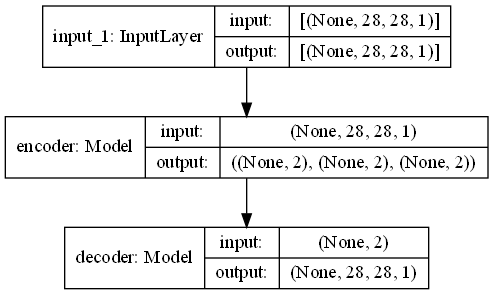

In [12]:
plot_model(vae,show_shapes=True)

In [13]:
#This cell trains the model
compile_vae(vae)
model_history = vae.fit(x=X_train,y=X_train,batch_size=128,epochs=50,validation_split=0.2,shuffle=True)

Train on 48000 samples, validate on 12000 samples
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/50
48000/48000 [==============================] - 7s 147us/sample - loss: 197.9053 - reco_loss: 192.6828 - kl_loss: 5.2225 - val_loss: 172.7180 - val_reco_loss: 168.1884 - val_kl_loss: 4.5297
Epoch 2/50
48000/48000 [==============================] - 6s 123us/sample - loss: 169.3657 - reco_loss: 164.7259 - kl_loss: 4.6398 - val_loss: 165.8096 - val_reco_loss: 161.0237 - val_kl_loss: 4.7859
Epoch 3/50
48000/48000 [==============================] - 6s 123us/sample - loss: 163.7959 - reco_loss: 158.8019 - kl_loss: 4.9940 - val_loss: 160.5120 - val_reco_loss: 155.4253 - val_kl_loss: 5.0867
Epoch 4/50
48000/48000 [==============================] - 6s 123us/sample - loss: 159.6341 - reco_loss: 154.3114 - kl_loss: 5.3226 - val_loss: 157.2391 - val_reco_loss: 151.6022 - val_kl_loss: 5.6369
Epoch 5/50
48000/48000 [==============================] 

Epoch 40/50
48000/48000 [==============================] - 6s 122us/sample - loss: 140.2914 - reco_loss: 133.6170 - kl_loss: 6.6744 - val_loss: 141.4280 - val_reco_loss: 134.6039 - val_kl_loss: 6.8240
Epoch 41/50
48000/48000 [==============================] - 6s 123us/sample - loss: 139.9747 - reco_loss: 133.2734 - kl_loss: 6.7012 - val_loss: 141.1090 - val_reco_loss: 134.3840 - val_kl_loss: 6.7250
Epoch 42/50
48000/48000 [==============================] - 6s 123us/sample - loss: 139.6531 - reco_loss: 132.9377 - kl_loss: 6.7154 - val_loss: 140.8279 - val_reco_loss: 134.0742 - val_kl_loss: 6.7537
Epoch 43/50
48000/48000 [==============================] - 6s 122us/sample - loss: 139.3941 - reco_loss: 132.6666 - kl_loss: 6.7275 - val_loss: 140.7298 - val_reco_loss: 133.9077 - val_kl_loss: 6.8221
Epoch 44/50
48000/48000 [==============================] - 6s 124us/sample - loss: 139.4048 - reco_loss: 132.6694 - kl_loss: 6.7354 - val_loss: 141.0308 - val_reco_loss: 134.3758 - val_kl_loss: 6.

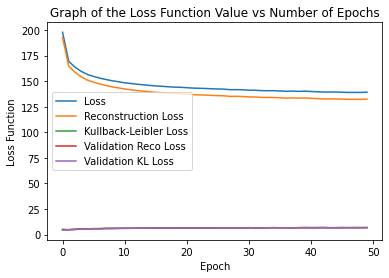

In [14]:
#This cell plots the loss functions
plt.plot(model_history.history['loss'],label='Loss')
plt.plot(model_history.history['reco_loss'],label='Reconstruction Loss')
plt.plot(model_history.history['kl_loss'],label='Kullback-Leibler Loss')
plt.plot(model_history.history['val_kl_loss'],label='Validation Reco Loss')
plt.plot(model_history.history['val_kl_loss'],label='Validation KL Loss')
plt.title("Graph of the Loss Function Value vs Number of Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss Function")
plt.legend()
plt.show()

#The loss and reconstruction losses are quite high but still decreasing and a convolutional layer
#probably would have decreased it more.

#### 5. Predict the test digits into the 2D laten space (1 mark)

- Use the encoder to predict images into the laten space
- Make a scatter plot per digit (use masking, see our first ML Lecture 2) and include a legend
- Include a grid.
- Discuss the results. Why do you think some digits overlap, and why are some clearly seperated? 

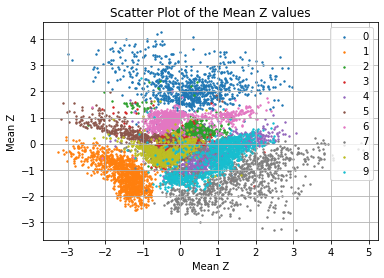

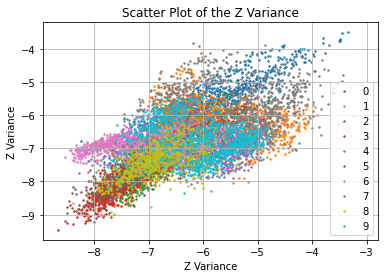

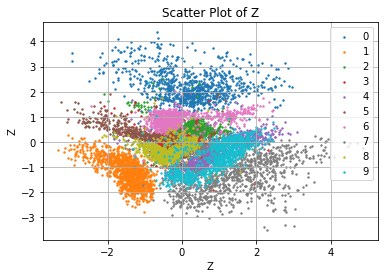

In [27]:
#This cell finds the encoder prediction 
#And plots the values of z, mean and variance.

enc_prediction = encoder.predict(X_test)

#plotting the mean
for i in range(10):
    plt.scatter(enc_prediction[0][np.where(y_test==i)][:,0],enc_prediction[0][np.where(y_test==i)][:,1],label=str(i),s=2)

plt.legend()
plt.title('Scatter Plot of the Mean Z values')
plt.xlabel('Mean Z')
plt.ylabel('Mean Z')
plt.grid()
plt.show()

#plotting the variance
for i in range(10):
    plt.scatter(enc_prediction[1][np.where(y_test==i)][:,0],enc_prediction[1][np.where(y_test==i)][:,1],label=str(i),s=2)

plt.legend()
plt.title('Scatter Plot of the Z Variance')
plt.xlabel('Z Variance')
plt.ylabel('Z Variance')
plt.grid()
plt.show()

#plotting z
for i in range(10):
    plt.scatter(enc_prediction[2][np.where(y_test==i)][:,0],enc_prediction[2][np.where(y_test==i)][:,1],label=str(i),s=2)

plt.legend()
plt.title('Scatter Plot of Z')
plt.xlabel('Z')
plt.ylabel('Z')
plt.grid()
plt.show()


We can see from these graphs that the main overlap comes from the numbers 8, 9, 4, 3, 6 and 5. The reason for this is that the numbers look similar when written down so the model has difficulty differentiating between the 2. For example, the 8 and 3 are almost entirely overlapped which is caused the fact that the 8 is basically just a 3 with the ends connected so the network sees these numbers as almost the same. Conversely, the numbers 1, 7 and 0 don't have much overlap as these numbers look very distinct from one another. For example a 7 & 0 are completely apart from each other as they don't share any common characteristics. 

#### 6. Generate samples across the latent space of the VAE (2 marks)

* Define an equally-spaced set of $\boldsymbol{N \approx 10}$ **points** along each of the two latent dimensions, that you want to sample (_e.g._ using the `np.linspace` method in the range $(-2,2)$). You can play around with this range in order to focus on areas you personally think might be interesting (look at your grid plot above).
* Convert these into a grid of pairs of coordinates using the `np.meshgrid` method.
* Define an $(N^{2}, 2)$ array, and fill it with all of these pairs of latent space coordinates (you'll need to `flatten` the two outputs from `np.meshgrid`).
* Get the decoder predictions (_i.e._ the generated images) for this set of $N^{2}$ coordinates in the latent space.
* Display them in a grid, _e.g._ using the `plt.imshow` method.
* Discuss the results.

In [18]:
#This cell creates the grid and decoder predictions
points = np.linspace(-2,2,10)
grid = np.array(np.meshgrid(points,points))
grid = grid.reshape(2,100)
coords = np.array(grid.transpose())

decoder_prediction = decoder.predict(coords)


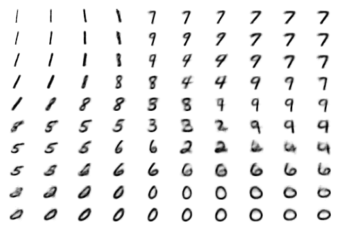

In [23]:
#Plotting the decoder predictions
for i in range(100):
    plt.subplot(10,10,i+1)
    plt.imshow(decoder_prediction[i],cmap=plt.cm.binary)
    plt.axis('off')
plt.show()

The numbers look good except for the 4s which look to be modified 9s (they have significant overlap in the plot above so it's to be expected) and the 8s and 3s are also a but hard to distinguish (again, also had significant overlap). The numbers 7, 0 and 1 are the best which is to be expected as they had the least overlap (although the 7s do start to merge into 9s).

_Indicative answer:_ This figure shows us that:
        
Using VAEs, we're able to generate new images that look like the original ones. That's a pretty big thing, and something we couldn't do with a standard (non-variational) auto-encoder.


# Generative Adversarial networks (2 marks)

Putting together a GAN by yourself is a big task and outside the scope of what we can cover.

Instead here we provide the building blocks for creating the GAN on the MNIST dataset. Your task is to go through individual components and show your understanding. The source material can be found [here](https://machinelearningmastery.com/how-to-develop-a-generative-adversarial-network-for-an-mnist-handwritten-digits-from-scratch-in-keras/) with ample explenations, so think of it as a short literature review, the point being to get you to engage with the material.


**Suggestion**: you could choose to answer the question in the same markdown block they are asked. Make the answer distiguishable by for example using a seperator by typing `---` on a new line.



#### 7. Discuss components of generative adverserial NN (0.5 marks)




In [40]:
# all imports needed from here
from numpy import expand_dims
from numpy import zeros
from numpy import ones
from numpy import vstack
from numpy.random import randn
from numpy.random import randint
from tensorflow.python.keras.datasets.mnist import load_data
from tensorflow.keras.optimizers import Adam
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense
from tensorflow.python.keras.layers import Reshape
from tensorflow.python.keras.layers import Flatten
from tensorflow.python.keras.layers import Conv2D
from tensorflow.python.keras.layers import Conv2DTranspose
from tensorflow.python.keras.layers import LeakyReLU
from tensorflow.python.keras.layers import Dropout
from matplotlib import pyplot
 

---

- Defined is the discriminator model using the `Sequential` keras function
    - What is the purpose of the discriminator?
    - Discuss the structure. What are the LeakyReLU and Dropout layers?
    - Why is binary crossentropy used as the loss function?
    
---

- The discriminator analyses the output data and determines if the data is real or fake data generated by the generator by finding the probability of it being real or fake. This has the effect that it improves the generator as it forces it to keep changing the output to keep fooling the discriminator. However, the discriminator also improves with every data piece it analyses so the positive feedback loop causes the model to make better and better outputs.


- The discriminator starts off with a convolutional layer with 64 dimensions before entering a LeakyReLu layer. The point of a LeakyReLU is that if a data set has a lot of 0 values (which in our case is true due to numbers not taking up much space) then neurons will "die" as they'll always get negative values and thus with a relu funtion, will return 0. LeakyRelu provides a small value for negative numbers so that the neurons will always have a small negative slope and contribute to the neural network. Next, comes a dropout layer which, in our case, removes 40% of the neurons at random to change the architecture of the nueral network. This has the advantage that it prevents overfitting as it breaks up the pattern of neurons correcting mistakes of previous layers, thus increasing the network's ability to fit general data rather than the specific training dataset. The layers are then repeated again to add depth to the network before being flattened and output as a single dimension.


- Binary cross-entropy is used as the discriminator produces either a True or False for real data or fake data, respectively. The binary cross-entropy loss function will calculate a probability for the data being real or fake. 



In [41]:
# define the standalone discriminator model
def define_discriminator(in_shape=(28,28,1)):
	model = Sequential()
	model.add(Conv2D(64, (3,3), strides=(2, 2), padding='same', input_shape=in_shape))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Dropout(0.4))
	model.add(Conv2D(64, (3,3), strides=(2, 2), padding='same')) 
	model.add(LeakyReLU(alpha=0.2))
	model.add(Dropout(0.4))
	model.add(Flatten())
	model.add(Dense(1, activation='sigmoid'))
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
	return model

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 14, 14, 64)        640       
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 7, 7, 64)          36928     
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 7, 7, 64)          0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 7, 7, 64)          0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 3136)             

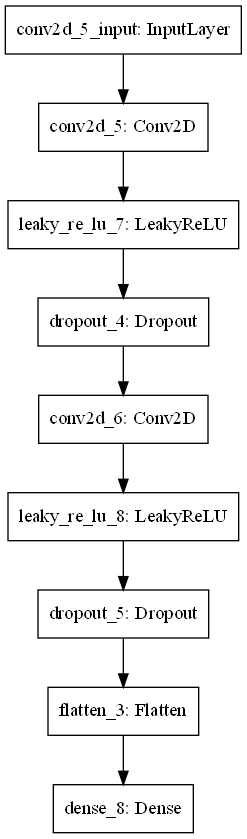

In [42]:
# create the discriminator
d_model = define_discriminator()
d_model.summary()
plot_model(d_model)

---
- Defined is the generator model
    - What is used as input to the generative model?
    - What is the Conv2DTranspose layer used for?
    - Why is sigmoid used as the activation function?
    
---

- The input to the generative model are random numbers sampled from a uniform distribution.


- The Conv2DTranspose function is the "UpSampling" analog of Conv2D (i.e., it's the inverse of Conv2D) as it's used to convolute backwards so instead of mapping pixels to features, it does the opposite.


- Sigmoid is used as the activation function because we want a single output node that represents an intensity of the pixel from 0 to 1.

In [43]:
# define the standalone generator model
def define_generator(latent_dim):
	model = Sequential()
	# foundation for 7x7 image
	n_nodes = 128 * 7 * 7
	model.add(Dense(n_nodes, input_dim=latent_dim))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Reshape((7, 7, 128)))
	# upsample to 14x14
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# upsample to 28x28
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Conv2D(1, (7,7), activation='sigmoid', padding='same'))
	return model
 

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 6272)              633472    
_________________________________________________________________
leaky_re_lu_9 (LeakyReLU)    (None, 6272)              0         
_________________________________________________________________
reshape_2 (Reshape)          (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 14, 14, 128)       262272    
_________________________________________________________________
leaky_re_lu_10 (LeakyReLU)   (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_transpose_3 (Conv2DTr (None, 28, 28, 128)       262272    
_________________________________________________________________
leaky_re_lu_11 (LeakyReLU)   (None, 28, 28, 128)      

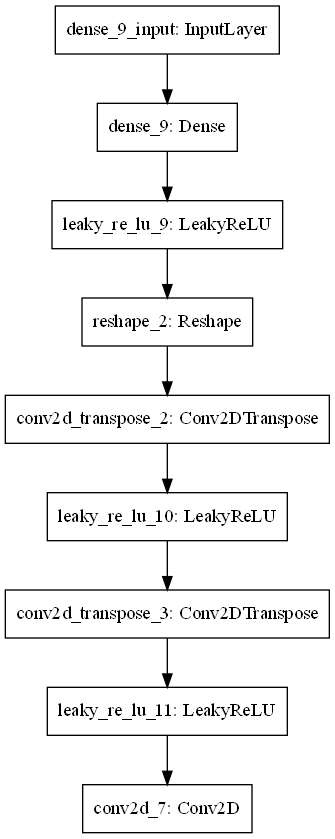

In [44]:
# size of the latent space
latent_dim = 100
# create the generator
g_model = define_generator(latent_dim)
g_model.summary()
plot_model(g_model)

---
- We define the GAN model as a sequence of both generator and discriminator
    - Explain the order of the sequence, and the flow of input to output, through the generator and discriminator
    - Notice the discriminator is not trainable in the gan model. Can you think of why that might be? This may become clear when we discuss the training loop.
    
---

- The gan starts off by taking in random numbers that have been fed into the generator with a shape of (7,7,1). The generator then upsamples this to a 28x28 image and assigns each pixel a value between 0-1 to create a fake image which is then fed into the discriminator. The discriminator will analyse the image by passing it through convolution and hidden layers before outputting the flattened array via a sigmoid function which will output a value between 0-1. This will determine if it's a real image or a fake image as the number corresponds to the probability of which one it is.


- The discriminator is not being trained as there are no real output images being passed through the discriminator -- only fake generated images. As a result of this, the training won't serve any practical purpose as the weights will be completely arbitrary with respect to reality so when true images are fed into the discriminator, it will be useless. 

In [45]:
# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model):
	# make weights in the discriminator not trainable
	d_model.trainable = False
	# connect them
	model = Sequential()
	# add generator
	model.add(g_model)
	# add the discriminator
	model.add(d_model)
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt)
	return model
 

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_5 (Sequential)    (None, 28, 28, 1)         1164289   
_________________________________________________________________
sequential_4 (Sequential)    (None, 1)                 40705     
Total params: 1,204,994
Trainable params: 1,164,289
Non-trainable params: 40,705
_________________________________________________________________


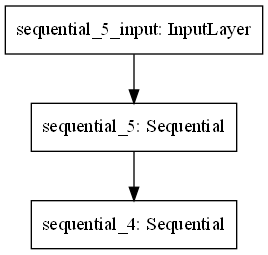

In [46]:
# create the gan
gan_model = define_gan(g_model, d_model)
gan_model.summary()
plot_model(gan_model)

---
##### 8. Discuss the training datasets (0.5 marks)

- Given are real mnist datasets. 
- `load_real_samples` prepares mnist
- `generate_real_samples` allows us to select a subset of data for barch training
    - what is this data used for?
    - what is the `y = ones((n_samples, 1))` varible used for?
    
---

- This data is used to train the discriminator (which, in turn, will train the generator to be better) as it now has real images to compare to the fake ones.

- The y variable is used to associate each pixel in X with a True value. This is to confirm that the X-image was a completely real image.

In [47]:
# load and prepare mnist training images
def load_real_samples():
	# load mnist dataset
	(trainX, _), (_, _) = load_data()
	# expand to 3d, e.g. add channels dimension
	X = expand_dims(trainX, axis=-1)
	# convert from unsigned ints to floats
	X = X.astype('float32')
	# scale from [0,255] to [0,1]
	X = X / 255.0
	return X
 
# select real samples
def generate_real_samples(dataset, n_samples):
	# choose random instances
	ix = randint(0, dataset.shape[0], n_samples)
	# retrieve selected images
	X = dataset[ix]
	y = ones((n_samples, 1))
	return X, y
 

---
- Given are functions to generate random numbers from laten space
    - use `generate_fake_samples` to create a single random image propegated through the generator. Discuss the result.

In [48]:
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(n_samples, latent_dim)
	return x_input
 
# use the generator to generate n fake examples, with class labels
def generate_fake_samples(g_model, latent_dim, n_samples):
	# generate points in latent space
	x_input = generate_latent_points(latent_dim, n_samples)
	# predict outputs
	X = g_model.predict(x_input)
	# create 'fake' class labels (0)
	y = zeros((n_samples, 1))
	return X, y

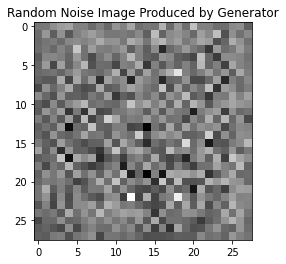

In [61]:
fake_X,fake_y = generate_fake_samples(g_model,latent_dim,1)

plt.imshow(np.vstack(fake_X),cmap=plt.cm.binary)
plt.title("Random Noise Image Produced by Generator")
plt.show()

#The image is definitely random noise as it has no visible structure
#Therefore, the generator is clearly untrained as it produces no discernible image

---
Some functions for saving GAN models and output images

In [62]:
# create and save a plot of generated images (reversed grayscale)
def save_plot(examples, epoch, n=10):
	# plot images
	for i in range(n * n):
		# define subplot
		pyplot.subplot(n, n, 1 + i)
		# turn off axis
		pyplot.axis('off')
		# plot raw pixel data
		pyplot.imshow(examples[i, :, :, 0], cmap='gray_r')
	# save plot to file
	filename = 'generated_plot_e%03d.png' % (epoch+1)
	pyplot.savefig(filename)
	pyplot.close()
# evaluate the discriminator, plot generated images, save generator model

def summarize_performance(epoch, g_model, d_model, dataset, latent_dim, n_samples=100):
	# prepare real samples
	X_real, y_real = generate_real_samples(dataset, n_samples)
	# evaluate discriminator on real examples
	_, acc_real = d_model.evaluate(X_real, y_real, verbose=0)
	# prepare fake examples
	x_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_samples)
	# evaluate discriminator on fake examples
	_, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)
	# summarize discriminator performance
	print('>Accuracy real: %.0f%%, fake: %.0f%%' % (acc_real*100, acc_fake*100))
	# save plot
	save_plot(x_fake, epoch)
	# save the generator model tile file
	filename = 'generator_model_%03d.h5' % (epoch + 1)
	g_model.save(filename) 

#### 9 Training the GANs (1 marks)

The GAN training sequnce is done in batches of data per epoch. Because the generator weights cannot be updated in the standard way, this is done iteratively in a loop. 


- Discuss the lines within the `j` loop. Explain how the generator and discriminator are trained in this context. 

---

- The loop starts off by randomly selecting real samples and generates fake samples which it then stacks together to create a list of real and fake images to act as the training set. The discriminator is then trained using these images in unspecified batches. Next, the loop generates latent space values to be fed into the generator and also inverts the labels by making the image appear real. This trains the GAN by making the generator try to circumvent the discriminator's detection abilities and therefore improving the images it produces. The last step in the j loop prints the loss functions corresponding to the epoch and batch number.

In [63]:
# train the generator and discriminator
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=5, n_batch=256):
	bat_per_epo = int(dataset.shape[0] / n_batch)
	half_batch = int(n_batch / 2)
	# manually enumerate epochs
	for i in range(n_epochs):
		# enumerate batches over the training set
		for j in range(bat_per_epo):
			# get randomly selected 'real' samples
			X_real, y_real = generate_real_samples(dataset, half_batch)
			# generate 'fake' examples
			X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
			# create training set for the discriminator
			X, y = vstack((X_real, X_fake)), vstack((y_real, y_fake))
			# update discriminator model weights
			d_loss, _ = d_model.train_on_batch(X, y)
			# prepare points in latent space as input for the generator
			X_gan = generate_latent_points(latent_dim, n_batch)
			# create inverted labels for the fake samples
			y_gan = ones((n_batch, 1))
			# update the generator via the discriminator's error
			g_loss = gan_model.train_on_batch(X_gan, y_gan)
			# summarize loss on this batch
			print('>%d, %d/%d, d=%.3f, g=%.3f' % (i+1, j+1, bat_per_epo, d_loss, g_loss))
		# evaluate the model performance, sometimes
		if (i+1) % 2 == 0:
			summarize_performance(i, g_model, d_model, dataset, latent_dim)
 

- Train the GAN model. 
    - This takes a very long time, so I would recommend aiming for 3 epochs and checking the figures that are generated (saved locally). They won't be good, but you will get some idea already that we don't have random noise
    - Discuss the print out. How do the loss functions change over time?
    - Generate some images with your new number generator and plot them. 
    - Feel free to try for more epoches (if you insist!). If you have some hours to waste, 10 should start showing some good digits, and by 50 you should get some good results.

In [64]:
# load image data
dataset = load_real_samples()
# train model
train(g_model, d_model, gan_model, dataset, latent_dim,n_epochs=3)

>1, 1/234, d=0.698, g=0.706
>1, 2/234, d=0.689, g=0.722
>1, 3/234, d=0.683, g=0.734
>1, 4/234, d=0.678, g=0.749
>1, 5/234, d=0.674, g=0.757
>1, 6/234, d=0.667, g=0.776
>1, 7/234, d=0.660, g=0.785
>1, 8/234, d=0.655, g=0.792
>1, 9/234, d=0.652, g=0.794
>1, 10/234, d=0.651, g=0.794
>1, 11/234, d=0.651, g=0.793
>1, 12/234, d=0.652, g=0.778
>1, 13/234, d=0.653, g=0.767
>1, 14/234, d=0.651, g=0.755
>1, 15/234, d=0.652, g=0.744
>1, 16/234, d=0.651, g=0.732
>1, 17/234, d=0.651, g=0.721
>1, 18/234, d=0.648, g=0.713
>1, 19/234, d=0.646, g=0.705
>1, 20/234, d=0.641, g=0.700
>1, 21/234, d=0.637, g=0.697
>1, 22/234, d=0.630, g=0.695
>1, 23/234, d=0.627, g=0.694
>1, 24/234, d=0.615, g=0.694
>1, 25/234, d=0.610, g=0.694
>1, 26/234, d=0.602, g=0.695
>1, 27/234, d=0.593, g=0.696
>1, 28/234, d=0.586, g=0.697
>1, 29/234, d=0.578, g=0.697
>1, 30/234, d=0.565, g=0.698
>1, 31/234, d=0.558, g=0.699
>1, 32/234, d=0.548, g=0.700
>1, 33/234, d=0.540, g=0.702
>1, 34/234, d=0.525, g=0.703
>1, 35/234, d=0.509, g=

>2, 40/234, d=0.655, g=0.846
>2, 41/234, d=0.662, g=0.856
>2, 42/234, d=0.662, g=0.815
>2, 43/234, d=0.654, g=0.809
>2, 44/234, d=0.653, g=0.786
>2, 45/234, d=0.665, g=0.744
>2, 46/234, d=0.669, g=0.744
>2, 47/234, d=0.657, g=0.713
>2, 48/234, d=0.676, g=0.713
>2, 49/234, d=0.681, g=0.690
>2, 50/234, d=0.684, g=0.713
>2, 51/234, d=0.678, g=0.694
>2, 52/234, d=0.683, g=0.671
>2, 53/234, d=0.662, g=0.676
>2, 54/234, d=0.683, g=0.661
>2, 55/234, d=0.679, g=0.687
>2, 56/234, d=0.681, g=0.660
>2, 57/234, d=0.699, g=0.689
>2, 58/234, d=0.680, g=0.671
>2, 59/234, d=0.696, g=0.663
>2, 60/234, d=0.687, g=0.675
>2, 61/234, d=0.694, g=0.683
>2, 62/234, d=0.716, g=0.671
>2, 63/234, d=0.701, g=0.658
>2, 64/234, d=0.718, g=0.663
>2, 65/234, d=0.717, g=0.678
>2, 66/234, d=0.715, g=0.667
>2, 67/234, d=0.727, g=0.682
>2, 68/234, d=0.731, g=0.660
>2, 69/234, d=0.737, g=0.661
>2, 70/234, d=0.741, g=0.678
>2, 71/234, d=0.731, g=0.664
>2, 72/234, d=0.738, g=0.689
>2, 73/234, d=0.749, g=0.690
>2, 74/234, d=

>3, 84/234, d=0.664, g=0.747
>3, 85/234, d=0.663, g=0.751
>3, 86/234, d=0.658, g=0.767
>3, 87/234, d=0.659, g=0.771
>3, 88/234, d=0.662, g=0.764
>3, 89/234, d=0.669, g=0.767
>3, 90/234, d=0.658, g=0.770
>3, 91/234, d=0.670, g=0.750
>3, 92/234, d=0.677, g=0.752
>3, 93/234, d=0.680, g=0.754
>3, 94/234, d=0.670, g=0.724
>3, 95/234, d=0.676, g=0.733
>3, 96/234, d=0.673, g=0.707
>3, 97/234, d=0.678, g=0.720
>3, 98/234, d=0.672, g=0.729
>3, 99/234, d=0.673, g=0.728
>3, 100/234, d=0.681, g=0.709
>3, 101/234, d=0.691, g=0.725
>3, 102/234, d=0.699, g=0.725
>3, 103/234, d=0.682, g=0.715
>3, 104/234, d=0.691, g=0.710
>3, 105/234, d=0.679, g=0.714
>3, 106/234, d=0.689, g=0.697
>3, 107/234, d=0.688, g=0.714
>3, 108/234, d=0.698, g=0.699
>3, 109/234, d=0.682, g=0.707
>3, 110/234, d=0.700, g=0.689
>3, 111/234, d=0.694, g=0.687
>3, 112/234, d=0.694, g=0.698
>3, 113/234, d=0.698, g=0.704
>3, 114/234, d=0.706, g=0.696
>3, 115/234, d=0.698, g=0.709
>3, 116/234, d=0.702, g=0.724
>3, 117/234, d=0.698, g=0.

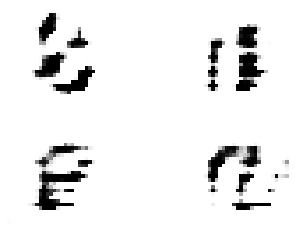

In [70]:
for i in range(4):
    plt.subplot(2,2,i+1)
    better_fake_X,better_fake_y = generate_fake_samples(g_model,latent_dim,1)
    plt.imshow(np.vstack(better_fake_X),cmap=plt.cm.binary)
    plt.axis('off')

plt.show()

The loss function for the discriminator decreases at first so it's getting better at finding the fake images, which causes the generator loss function to increase as a result. However, at some points (e.g., epoch 1 batch 100) the generator tries something random which manages to throw off the discriminator completely and the loss functions drastically decrease for the generator whilst for the discriminator, they become very high. The loss functions tend to stabilise after the first epoch but the see-sawing of loss functions is still visible; when the loss function function of the discriminator decreases, the loss function of the generator increases and vice versa.

The images here don't look very good although the bottom right one looks a little like a 2 and the top right a 0. In comparison to the one above, however, they look a lot better as they no longer look like random noise but more like abstract art. Print them out, put Picasso's name on it and you could sell them for millions!